In [5]:
import torch
import numpy as np
import scipy as sp
import scipy.sparse as spsp
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from argparse import ArgumentParser

from tick.base import TimeFunction
from tick.hawkes import HawkesKernelTimeFunc, SimuHawkes, SimuHawkesExpKernels, \
    SimuHawkesSumExpKernels, HawkesKernel0, HawkesKernelExp, HawkesKernelPowerLaw, SimuHawkesMulti
from tick.plot import plot_point_process


def random_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    
def simulate_hawkes(n_nodes, n_decays, n_realiz, end_time, dt, max_jumps=1000, seed=None, adj_density=0.25):
    tss = []

    baselines = np.random.rand(n_nodes) / n_nodes
    #baselines = spsp.rand(1, n_nodes, density=0.5).toarray()[0] / n_nodes
    decays = 5 * np.random.rand(n_nodes, n_nodes)
    adjacency = spsp.rand(n_nodes, n_nodes, density=adj_density).toarray()
    # Simulation

    for i in range(n_realiz):
        seed_ = seed + i if seed is not None else None
        hawkes = SimuHawkesExpKernels(
            baseline=baselines, decays=decays, adjacency=adjacency, seed=seed_)
        hawkes.adjust_spectral_radius(0.8)
        hawkes.max_jumps = max_jumps

        hawkes.end_time = end_time
        hawkes.verbose = False

        hawkes.track_intensity(dt)
        hawkes.simulate()
        tss.append(hawkes.timestamps)
        
        plot_point_process(hawkes)
    
    return tss

def random_me(seed):
    random_seed(seed)
    return np.pi/5 + np.pi/5*np.random.random(), np.pi/5 + np.pi/5*np.random.random(), np.pi/5 + np.pi/5*np.random.random()

class Random_sin:
    def __init__(self, C, seed):
        self.b = np.zeros((C,C))
        self.w = np.zeros((C,C))
        self.s = np.zeros((C,C))
        print ('seed:', seed)
        for c in range(C):
            for c1 in range(C):
                self.b[c,c1], self.w[c,c1],\
                self.s[c,c1] = random_me(seed)
#                 print (self.b[c, c1], self.w[c, c1], self.s[c, c1])
    def get_kernel(self, c, c1, t):
        return self.b[c,c1]*\
                            (1-np.cos(self.w[c,c1]*\
                            (t-self.s[c,c1])))

# def simulate_hawkes_sin(n_nodes, n_swcays, n_realiz, end_time, dt, max_jumps = 1000, seed = 20):
#     tss = []
#     # The elements of exogenous base intensity are sampled uniformly from [0, 1]
#     baseline = np.random.random(n_nodes)
#     for i in range(n_realiz):
#         seed_ = seed + i if seed is not None else None
#         hawkes = (SimuHawkes(baseline = baseline, end_time = end_time,\
#                          verbose = False, force_simulation = True, seed=seed_))
        
#         body = Random_sin(n_nodes)
#         times = np.linspace(0, 1, 10) # 0, 1, 10, time = 10
#         for c in range(n_nodes):
#             for c1 in range(n_nodes):
#                 ys = body.get_kernel(c,c1,times)
#                 tf = TimeFunction([times, ys])
#                 kernel = HawkesKernelTimeFunc(tf)
#                 hawkes.set_kernel(c,c1,kernel)
        
#         hawkes.max_jumps = max_jumps

#         hawkes.end_time = end_time
#         hawkes.verbose = False

#         hawkes.track_intensity(dt)
#         hawkes.simulate()
#         tss.append(hawkes.timestamps)
        
#         plot_point_process(hawkes)
        
#     return tss

def simulate_hawkes_sin(n_nodes, n_swcays, n_realiz, end_time, dt, max_jumps = 1000, seed = 20):
    tss = []
    # The elements of exogenous base intensity are sampled uniformly from [0, 1]
    baseline = np.random.random(n_nodes)

    hawkes = (SimuHawkes(baseline = baseline, force_simulation = True))
    
    body = Random_sin(n_nodes, seed)
    times = np.linspace(0, 1, 10) # 0, 1, 10, time = 10
    for c in range(n_nodes):
        for c1 in range(n_nodes):
            ys = body.get_kernel(c,c1,times)
            tf = TimeFunction([times, ys])
            kernel = HawkesKernelTimeFunc(tf)
            hawkes.set_kernel(c,c1,kernel)
    
    multi = SimuHawkesMulti(hawkes, n_simulations=n_realiz)
    multi.end_time = [end_time for i in range(n_realiz)]
    multi.simulate()
        
    tss = multi.timestamps
#     for i in range (n_realiz):
#         plot_point_process(multi.get_single_simulation(i))

    print (tss)

    return tss

# def simulate_hawkes_sin_trunc(n_nodes, n_swcays, n_realiz, end_time, dt, max_jumps = 1000, seed = 20):
#     tss = []
#     # The elements of exogenous base intensity are sampled uniformly from [0, 1]
#     baseline = np.random.random(n_nodes)

#     for i in range(n_realiz):
#         seed_ = seed + i if seed is not None else None
#         hawkes = (SimuHawkes(baseline = baseline, end_time = end_time,\
#                          verbose = False, force_simulation = True, seed=seed_))
        
#         body = Random_sin_trunc(n_nodes)
#         times = np.linspace(0, 2.5, 5) # 0, 3, 5 - not bad, 0, 2.5, 10 - good
#         for c in range(n_nodes):
#             for c1 in range(n_nodes):
#                 ys = body.get_kernel(c,c1,times)
#                 tf = TimeFunction([times, ys])
#                 kernel = HawkesKernelTimeFunc(tf)
#                 hawkes.set_kernel(c,c1,kernel)
        
#         hawkes.max_jumps = max_jumps

#         hawkes.end_time = end_time
#         hawkes.verbose = False

#         hawkes.track_intensity(dt)
#         hawkes.simulate()
#         tss.append(hawkes.timestamps)
        
#         plot_point_process(hawkes)
            
#     return tss 

def simulate_hawkes_sin_trunc(n_nodes, n_swcays, n_realiz, end_time, dt, max_jumps = 1000, seed = 20):
    tss = []
    # The elements of exogenous base intensity are sampled uniformly from [0, 1]
    baseline = np.random.random(n_nodes)
    
    hawkes = (SimuHawkes(baseline = baseline, force_simulation=True))
        
    body = Random_sin_trunc(n_nodes, seed)
    times = np.linspace(0, 1, 10)
    for c in range(n_nodes):
        for c1 in range(n_nodes):
            ys = body.get_kernel(c,c1,times)
            tf = TimeFunction([times, ys])
            kernel = HawkesKernelTimeFunc(tf)
            hawkes.set_kernel(c,c1,kernel)
    
    multi = SimuHawkesMulti(hawkes, n_simulations=n_realiz)
    multi.end_time = [end_time for i in range(n_realiz)]
    multi.simulate()
        
    tss = multi.timestamps        
    return tss

class Random_sin_trunc:
    def __init__(self, C, seed):
        self.b = np.zeros((C,C))
        self.w = np.zeros((C,C))
        self.s = np.zeros((C,C))
        for c in range(C):
            for c1 in range(C):
                self.b[c,c1], self.w[c,c1],\
                self.s[c,c1] = random_me(seed)
    def get_kernel(self, c, c1, t):
        return 2*self.b[c,c1]*np.round(self.b[c,c1]*\
                            (1-np.cos(self.w[c,c1]*\
                            (t-self.s[c,c1])))/2/self.b[c,c1])

def simulate_clusters(n_clusters, n_nodes, n_decays, n_realiz, end_time, dt, max_jumps, seed=None, adj_density=None, sim_type = 'exp'):
    clusters = []
    for i in range(n_clusters):
        seed_ = seed + i if seed is not None else None
        if sim_type == 'exp':
            clusters.append(simulate_hawkes(n_nodes, n_decays, n_realiz, end_time, dt, max_jumps, seed_, adj_density))
        elif sim_type == 'sin':
            clusters.append(simulate_hawkes_sin(n_nodes, n_decays, n_realiz, end_time, dt, max_jumps, seed_))
        elif sim_type == 'trunc':
            clusters.append(simulate_hawkes_sin_trunc(n_nodes, n_decays, n_realiz, end_time, dt, max_jumps, seed_))
        else:
            raise ValueError('Unknown sim type')
    return clusters

def convert_seq_to_df(timestamps):
    ts = []
    cs = []

    for c, tc in enumerate(timestamps):
        cs += [c]*len(tc)
        ts += list(tc)
    s = list(zip(ts, cs))
    s = list(sorted(s, key=lambda x: x[0]))
    s = np.array(s)
    df = pd.DataFrame(data=s, columns=['time', 'event'])
    
    return df

def convert_clusters_to_dfs(clusters):
    dfs = []
    cluster_ids = []

    for cl_id, cluster in enumerate(clusters):
        cluster_ids += [cl_id] * len(cluster)
        for realiz in cluster:
            df = convert_seq_to_df(realiz)
            dfs.append(df)

    return dfs, cluster_ids

def mmain(n_clusters=3, n_nodes=5, 
                n_decays=3, n_realiz_per_cluster=100, end_time=100, dt=0.01, max_jumps=1000, seed=0, adj_density=0.25, sim_type='exp', save_dir='tmp'):
    print('Simulating...')
    clusters = simulate_clusters(n_clusters, n_nodes, 
                n_decays, n_realiz_per_cluster, end_time, dt, max_jumps, seed, adj_density, sim_type)
    dfs, cluster_ids = convert_clusters_to_dfs(clusters)
    print('Saving...')
    save_dir = Path('data/simulated_Hawkes', save_dir) # 'data/simulated_Hawkes',
    save_dir.mkdir(exist_ok=True, parents=True)
    for i, df in enumerate(dfs):
        df.to_csv(Path(save_dir, f'{i+1}.csv').open('w'))

    pd.DataFrame(data=np.array(cluster_ids), columns=['cluster_id']).to_csv(Path(save_dir, f'clusters.csv').open('w'))
    print('Finished.')

In [6]:
mmain(2, sim_type='sin', n_realiz_per_cluster=1, end_time=20, seed=0, save_dir='tmp_sin_K2_C5_2_TMP')

Simulating...
seed: 0
---------------------------------------------
Launching simulation using SimuHawkesMulti...
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 7.68e-02 seconds.
Done simulating using SimuHawkesMulti in 3.46e-01 seconds.
[[array([ 0.34292785,  0.63737016,  0.67575493,  0.72662713,  0.86389338,
        0.87009648,  1.74236486,  1.95177657,  2.29730295,  2.57881525,
        2.59594706,  2.62083395,  2.66436808,  2.71777615,  2.85763434,
        2.89149494,  2.89409394,  2.96085824,  2.97076148,  3.17255885,
        3.20401893,  3.23721549,  3.27331777,  3.37699058,  3.50055284,
        3.52550768,  3.74594709,  3.89696165,  3.99908261,  4.08851715,
        4.11633592,  4.1417145 ,  4.30038386,  4.51104385,  4.57060702,
        4.69407323,  4.73005387,  4.84155743,  4.85388955,  5.00846294,
        5.11827194,  5.26630241,  5.31742013,  5.50425013,  5.58684013,
        5.67775429,  5.73859837,  5.74835

In [29]:
mmain(3, sim_type='sin', n_realiz_per_cluster=400, end_time=20, seed=0, save_dir='tmp_sin_K3_C5_2')

Simulating...
seed: 0
---------------------------------------------
Launching simulation using SimuHawkesMulti...
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 2.15e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 3.09e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 3.48e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 2.48e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 3.50e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.60e-02 seconds.
----------------------------------------
Launching simulation using Si

Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 6.07e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 4.96e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 2.26e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 3.84e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 2.70e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 2.30e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 7.98e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done si

Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 2.16e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 3.09e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.84e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 2.43e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 2.61e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 2.86e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 2.96e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done si

Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 2.18e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 2.93e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 3.71e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 2.84e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 4.01e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 3.87e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 2.80e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done si

Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.67e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.68e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.35e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.23e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.29e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.41e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.31e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done si

Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.49e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.29e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.10e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.81e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 2.11e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.31e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.49e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done si

Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.28e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.23e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.39e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.29e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.20e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.28e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.29e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done si

Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.33e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.56e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.39e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.34e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.28e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.40e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.26e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done si

Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.38e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.66e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.33e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.61e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 2.04e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.33e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.54e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done si

Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.25e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.54e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 2.04e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.33e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.24e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.66e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.43e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done si

Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 2.09e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.46e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.25e-02 seconds.
Done simulating using SimuHawkesMulti in 1.99e+01 seconds.
Saving...
Finished.


In [30]:
mmain(2, sim_type='sin', n_realiz_per_cluster=400, end_time=20, seed=0, save_dir='tmp_sin_K2_C5_2')

Simulating...
seed: 0
---------------------------------------------
Launching simulation using SimuHawkesMulti...
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 2.16e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 3.10e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.67e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.83e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.91e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.39e-02 seconds.
----------------------------------------
Launching simulation using Si

Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.67e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 2.89e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.83e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 5.66e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 2.17e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.92e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 2.66e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done si

Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 2.61e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 3.20e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.97e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.93e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 2.38e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 3.75e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 2.86e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done si

Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 2.80e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.92e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.74e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 2.54e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 2.13e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.57e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.69e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done si

Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.49e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.87e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.48e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.62e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 2.07e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.55e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.45e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done si

Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.26e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.36e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 2.20e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 2.27e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.33e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.27e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.18e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done si

Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.22e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.21e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.16e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.45e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.30e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.29e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.26e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done si

In [31]:
mmain(4, sim_type='sin', n_realiz_per_cluster=400, end_time=20, seed=0, save_dir='tmp_sin_K4_C5_2')

Simulating...
seed: 0
---------------------------------------------
Launching simulation using SimuHawkesMulti...
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 2.16e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.54e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 2.14e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.76e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.59e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.81e-02 seconds.
----------------------------------------
Launching simulation using Si

Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 2.27e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 2.48e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 2.32e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 2.11e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 2.84e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.68e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.66e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done si

Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.77e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.61e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 2.53e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.83e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 3.49e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.76e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.82e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done si

Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.68e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 2.54e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 2.30e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 2.19e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 2.24e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.99e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.99e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done si

Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.30e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.33e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.60e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 2.07e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.29e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.31e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.48e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done si

Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.22e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.57e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.48e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 2.03e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.38e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.54e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 2.21e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done si

Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.22e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.14e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.19e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.25e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.39e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.28e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 2.02e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done si

Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.41e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.60e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.24e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.35e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.25e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.27e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.80e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done si

Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 2.46e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.99e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.36e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.75e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.48e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 2.06e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.56e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done si

Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.35e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.35e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.28e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.23e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.59e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.26e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.53e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done si

Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.28e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.25e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.76e-02 seconds.
Done simulating using SimuHawkesMulti in 2.04e+01 seconds.
seed: 3
---------------------------------------------
Launching simulation using SimuHawkesMulti...
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 2.31e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.04e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 2.16e-02 seconds.
----------------------------------------
Launching simulation usin

Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 2.33e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.51e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.81e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 2.02e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 2.03e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.78e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.30e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done si

Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.71e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.57e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.98e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.84e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.56e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.26e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.37e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done si

Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.88e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.67e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.69e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.35e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.85e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.61e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.82e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done si

In [2]:
mmain(5, sim_type='sin', n_realiz_per_cluster=400, end_time=20, seed=0, save_dir='tmp_sin_K5_C5_2')

Simulating...
seed: 0
---------------------------------------------
Launching simulation using SimuHawkesMulti...
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 4.68e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.31e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.45e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 3.86e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 2.95e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.19e-02 seconds.
----------------------------------------
Launching simulation using Si

Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.80e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 3.42e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 4.46e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 3.74e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.36e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 2.44e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.90e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done si

Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 2.57e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.88e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 2.23e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.52e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 2.19e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.24e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 7.41e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done si

Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.72e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 2.19e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 2.09e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 3.86e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 3.34e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 2.58e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 2.51e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done si

Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 8.59e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 5.26e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 6.35e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 5.76e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 9.31e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 8.42e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 8.04e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done si

Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 2.54e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.06e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 5.81e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 3.76e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 7.07e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 8.99e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.01e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done si

Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 5.81e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 5.09e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.08e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 8.71e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 9.86e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.11e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.18e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done si

Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 4.37e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 7.94e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 7.35e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 3.95e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 4.05e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 7.61e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 6.34e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done si

Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 7.91e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 4.22e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 7.07e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 4.26e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 7.28e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 7.82e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 4.51e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done si

Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.08e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 7.73e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 2.53e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.01e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 9.55e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 9.53e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 8.56e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done si

Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 6.32e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 3.91e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 5.05e-03 seconds.
Done simulating using SimuHawkesMulti in 1.87e+01 seconds.
seed: 3
---------------------------------------------
Launching simulation using SimuHawkesMulti...
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 8.68e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 7.58e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 5.33e-03 seconds.
----------------------------------------
Launching simulation usin

Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 5.42e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 6.76e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.06e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.02e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 7.52e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 8.03e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 4.68e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done si

Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 7.06e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 7.19e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 5.96e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 4.61e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 9.14e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 8.27e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 9.45e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done si

Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 9.59e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 8.65e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 7.48e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 4.73e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 3.97e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 6.82e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 4.81e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done si

KeyboardInterrupt: 

In [35]:
mmain(2, sim_type='trunc', n_realiz_per_cluster=400, end_time=20, seed=0, save_dir='tmp_trunc_K2_C5_2')

Simulating...
---------------------------------------------
Launching simulation using SimuHawkesMulti...
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 7.98e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 6.04e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.02e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 4.51e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 7.21e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 6.02e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes

Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 9.32e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 8.95e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 8.61e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 8.87e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 8.03e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.02e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.13e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done si

Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 8.20e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 7.82e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 4.63e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 6.61e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 4.02e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 9.77e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.05e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done si

Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 4.84e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 4.78e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 5.66e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 5.08e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 8.10e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 8.30e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 7.28e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done si

Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 6.30e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 9.71e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 5.69e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 5.74e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 8.15e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 8.70e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 8.76e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done si

Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 9.39e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.09e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 8.76e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.05e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 8.70e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 6.96e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.09e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done si

Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 6.04e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 4.84e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 5.12e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 7.33e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.11e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 5.80e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.24e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done si

In [36]:
mmain(3, sim_type='trunc', n_realiz_per_cluster=400, end_time=20, seed=0, save_dir='tmp_trunc_K3_C5_2')

Simulating...
---------------------------------------------
Launching simulation using SimuHawkesMulti...
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.01e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.38e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.16e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 4.57e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 4.93e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 6.22e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes

Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.00e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 9.20e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.04e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 5.03e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 6.14e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 5.48e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 5.66e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done si

Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 6.91e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 4.64e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 4.79e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 7.92e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.04e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 8.05e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 6.81e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done si

Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 7.96e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 6.82e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 7.43e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 5.30e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 6.39e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 9.31e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 6.93e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done si

Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 9.46e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 5.00e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 7.05e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 8.27e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 7.13e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 7.02e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 5.22e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done si

Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.08e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.00e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.05e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 6.01e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 8.39e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 7.68e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.01e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done si

Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 4.55e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 6.33e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 4.47e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 4.50e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 6.46e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 4.76e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 4.85e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done si

Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 5.70e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 5.55e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 5.57e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 8.35e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 9.99e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 6.09e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 5.70e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done si

Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 8.10e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 6.13e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 7.21e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 8.08e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 5.88e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 7.87e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 8.91e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done si

Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.27e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 8.80e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 7.54e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 7.31e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 4.39e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 7.40e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 5.24e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done si

Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 7.11e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 4.60e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 5.38e-03 seconds.
Done simulating using SimuHawkesMulti in 1.59e+01 seconds.
Saving...
Finished.


In [37]:
mmain(4, sim_type='trunc', n_realiz_per_cluster=400, end_time=20, seed=0, save_dir='tmp_trunc_K4_C5_2')

Simulating...
---------------------------------------------
Launching simulation using SimuHawkesMulti...
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 9.61e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 7.31e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 6.60e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 7.19e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 9.02e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 7.06e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes

Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 4.89e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 6.00e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 5.35e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 5.39e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 4.76e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 6.35e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 7.32e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done si

Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 5.87e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 6.35e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 7.46e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 6.46e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 4.63e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 5.24e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 6.78e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done si

Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 5.83e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 7.43e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 8.30e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 4.77e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 4.69e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 4.77e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 7.87e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done si

Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.04e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 4.49e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.03e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 4.47e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 8.74e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 7.01e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 5.91e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done si

Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 6.24e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.01e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.20e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 9.68e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 8.14e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 9.50e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.13e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done si

Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 6.64e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 6.77e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 5.24e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 6.81e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 7.33e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 5.62e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 6.45e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done si

Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.03e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 6.26e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 5.77e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 5.64e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 5.17e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 6.72e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 6.47e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done si

Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 8.73e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.22e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.53e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.21e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 8.59e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.11e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.12e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done si

Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 4.72e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 6.83e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 7.24e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 5.09e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 6.11e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 6.83e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 7.20e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done si

Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 7.93e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 6.84e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 4.34e-03 seconds.
Done simulating using SimuHawkesMulti in 1.64e+01 seconds.
---------------------------------------------
Launching simulation using SimuHawkesMulti...
----------------------------------------Launching simulation using SimuHawkes...
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.16e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 9.29e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.11e-02 seconds.
----------------------------------

Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 6.60e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 5.16e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 4.84e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 6.75e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 6.95e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 4.95e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 5.17e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done si

Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 7.58e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 8.03e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 4.97e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 5.06e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 5.18e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 7.63e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 6.12e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done si

Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 8.20e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 8.49e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 8.97e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 7.85e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 4.96e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 5.13e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 6.23e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done si

In [38]:
mmain(5, sim_type='trunc', n_realiz_per_cluster=400, end_time=20, seed=0, save_dir='tmp_trunc_K5_C5_2')

Simulating...
---------------------------------------------
Launching simulation using SimuHawkesMulti...
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 9.10e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 6.35e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 4.49e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 6.53e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 6.30e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 5.17e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes

Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 8.30e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 5.75e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 4.86e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 5.65e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 8.63e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 7.90e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 7.75e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done si

Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 6.26e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 8.34e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.12e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 8.44e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 8.11e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 8.63e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 5.68e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done si

Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 7.86e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 7.14e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 6.97e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 5.27e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 5.32e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 8.57e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 7.69e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done si

Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 4.78e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 4.98e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 7.32e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 8.07e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 9.46e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 9.84e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 7.82e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done si

Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 6.36e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 7.79e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 9.58e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 6.96e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 8.20e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 8.60e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 7.76e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done si

Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.01e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 8.16e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 5.25e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 4.56e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 6.95e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 4.80e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 5.01e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done si

Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 5.17e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 5.79e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 5.59e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 6.89e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 6.42e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 4.56e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 7.15e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done si

Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 8.41e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 9.00e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 7.73e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 7.98e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 4.79e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 5.78e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 7.20e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done si

Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.46e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 8.54e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 7.65e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 8.64e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.23e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.02e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 8.43e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done si

Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 6.95e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 4.95e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 4.64e-03 seconds.
Done simulating using SimuHawkesMulti in 1.62e+01 seconds.
---------------------------------------------
Launching simulation using SimuHawkesMulti...
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.40e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 6.94e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.08e-02 seconds.
----------------------------------------
Launching simulation using SimuHa

Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 7.94e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.08e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.05e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.20e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 5.80e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.39e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 9.05e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done si

Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 5.02e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 9.05e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.03e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 6.72e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 7.13e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 7.43e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 4.64e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done si

Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 7.75e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 8.06e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 4.51e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 4.87e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 7.39e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 6.82e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 5.08e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done si

Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 5.40e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 7.90e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 7.89e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 7.74e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.00e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 4.51e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 6.38e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done si

Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 8.29e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 5.14e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 6.93e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 7.76e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 7.82e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 7.11e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 4.83e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done si

Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 4.14e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 7.25e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 6.38e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 4.43e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 8.01e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 9.09e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 7.13e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done si

In [ ]:
jhgjhgjhgjh

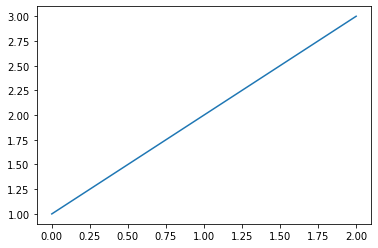

In [1]:
import matplotlib.pyplot as plt

plt.plot([1, 2, 3])

In [ ]:
jhgjhgjhgjh

In [ ]:
jhgjhgjhgjh

In [ ]:
jhgjhgjhgjh

### Sin

In [2]:
mmain(2, sim_type='sin', n_realiz_per_cluster=400, end_time=20, seed=None, save_dir='tmp_sin_K2_C5_1')

Simulating...
---------------------------------------------
Launching simulation using SimuHawkesMulti...
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.99e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.40e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.95e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.76e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.64e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.98e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes

Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.34e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.25e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.29e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.28e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.20e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.78e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.88e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done si

Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.42e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.46e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.41e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.27e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.19e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.37e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.34e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done si

Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.37e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.35e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.99e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 2.09e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 2.31e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.51e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 2.36e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done si

Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 2.35e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.48e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.39e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.99e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 2.17e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.40e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.33e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done si

Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.74e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.42e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.41e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.55e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.40e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 2.87e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.67e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done si

Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 2.03e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.25e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 2.15e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.37e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 2.28e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.47e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.38e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done si

In [3]:
mmain(3, sim_type='sin', n_realiz_per_cluster=400, end_time=20, seed=None, save_dir='tmp_sin_K3_C5_1')

Simulating...
---------------------------------------------
Launching simulation using SimuHawkesMulti...
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 2.17e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 2.06e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.94e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.48e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.50e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.98e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes

Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.96e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.84e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.53e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.64e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 2.12e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.86e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 2.23e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done si

Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.49e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.44e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.29e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.92e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 2.29e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.52e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.86e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done si

Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.87e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.96e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.41e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.59e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.66e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.33e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 2.17e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done si

Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.41e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.44e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.37e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.31e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.68e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 2.17e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.67e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done si

Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.31e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.43e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.32e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 2.13e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 2.13e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.63e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 2.52e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done si

Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.13e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.45e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.66e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.81e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.26e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.99e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.37e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done si

Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.32e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.32e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.36e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.58e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.37e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.35e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.59e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done si

Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.77e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 2.06e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.39e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 2.18e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.72e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 2.35e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 2.32e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done si

Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.77e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.42e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.58e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.28e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.28e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.45e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.41e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done si

Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 2.68e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.95e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.64e-02 seconds.
Done simulating using SimuHawkesMulti in 2.07e+01 seconds.
Saving...
Finished.


In [4]:
mmain(4, sim_type='sin', n_realiz_per_cluster=400, end_time=20, seed=None, save_dir='tmp_sin_K4_C5_1')

Simulating...
---------------------------------------------
Launching simulation using SimuHawkesMulti...
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 2.09e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.20e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.31e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.82e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 2.31e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 2.39e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes

Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 2.27e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.41e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.76e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 2.33e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 2.49e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 2.29e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 2.46e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done si

Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.92e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 2.15e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 2.39e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 2.10e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 2.10e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.66e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 3.58e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done si

Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 2.64e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.60e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 3.18e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 2.45e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 2.29e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 2.13e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 3.22e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done si

Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 2.14e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.92e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 2.24e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.82e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 2.31e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.37e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 2.06e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done si

Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 2.82e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.48e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.91e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 2.83e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 2.19e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.60e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 2.37e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done si

Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 2.34e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.99e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 2.41e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 2.52e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 2.60e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.96e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 2.13e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done si

Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.32e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 2.23e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 2.23e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 2.97e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 2.11e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 2.15e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 2.14e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done si

Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 2.04e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 2.56e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 2.39e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 2.66e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 2.76e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 2.98e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 2.78e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done si

Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 2.12e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.44e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 2.12e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.64e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.59e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 2.44e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.41e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done si

Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.69e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 2.67e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 2.76e-02 seconds.
Done simulating using SimuHawkesMulti in 3.07e+01 seconds.
---------------------------------------------
Launching simulation using SimuHawkesMulti...
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 2.40e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.74e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.57e-02 seconds.
----------------------------------------
Launching simulation using SimuHa

Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 2.49e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 2.92e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 3.07e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.26e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.37e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 3.20e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.45e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done si

Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 2.69e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 2.91e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.31e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.89e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.79e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.47e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.94e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done si

Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 2.99e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.26e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.42e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 2.67e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.66e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 2.78e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 2.14e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done si

In [5]:
mmain(5, sim_type='sin', n_realiz_per_cluster=400, end_time=20, seed=None, save_dir='tmp_sin_K5_C5_1')

Simulating...
---------------------------------------------
Launching simulation using SimuHawkesMulti...
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 2.14e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.65e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.24e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.44e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.20e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 2.08e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes

Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 2.53e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 2.09e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.40e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 2.86e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.39e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 2.60e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.50e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done si

Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 2.20e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.51e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.91e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.45e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 2.24e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.16e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 2.46e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done si

Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.22e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.71e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.10e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.16e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.16e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.53e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 2.33e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done si

Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.39e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.42e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.60e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 3.25e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 2.47e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.49e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 2.50e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done si

Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.20e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.36e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 2.03e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 2.45e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.19e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.76e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.37e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done si

Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 3.04e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.63e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.33e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 2.13e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 2.31e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.53e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 2.45e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done si

Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 2.12e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.24e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.29e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.33e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.30e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.64e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.51e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done si

Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.37e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 2.18e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 2.08e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.28e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.31e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 2.52e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.32e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done si

Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.39e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.81e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 2.11e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.32e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.36e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 2.73e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.39e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done si

Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 2.18e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.30e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 2.29e-02 seconds.
Done simulating using SimuHawkesMulti in 2.54e+01 seconds.
---------------------------------------------
Launching simulation using SimuHawkesMulti...
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 3.56e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.29e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 2.57e-02 seconds.
----------------------------------------
Launching simulation using SimuHa

Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.78e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 2.04e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 2.15e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 2.67e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.90e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 3.47e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 2.02e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done si

Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 3.43e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.47e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 3.09e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 2.34e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 4.56e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 2.09e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 3.02e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done si

Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.64e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 2.78e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 3.45e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.58e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.52e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.39e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 2.15e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done si

Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 2.43e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.19e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.24e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.71e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.72e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.43e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.72e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done si

Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.16e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.59e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.57e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.20e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.25e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.28e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.99e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done si

Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.14e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.17e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 2.17e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.10e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.11e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.16e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 2.10e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done si

### Trunc

In [6]:
mmain(2, sim_type='trunc', n_realiz_per_cluster=400, end_time=20, seed=None, save_dir='tmp_trunc_K2_C5_1')

Simulating...
---------------------------------------------
Launching simulation using SimuHawkesMulti...
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 7.71e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 4.57e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 8.57e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.25e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 6.33e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 5.77e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes

Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 4.64e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 8.55e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.39e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.16e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 4.08e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 7.90e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 7.68e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done si

Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 8.51e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.10e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.22e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.96e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 2.10e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.23e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.04e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done si

Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.02e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.04e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 6.68e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 4.17e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 7.57e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 6.99e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 8.22e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done si

Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.85e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 4.07e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 8.79e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 9.00e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 8.99e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 8.38e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 8.39e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done si

Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 4.50e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 7.82e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 4.79e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 6.96e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 5.21e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 5.30e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 4.34e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done si

Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 5.15e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 4.52e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 6.39e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 4.66e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 4.48e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 5.64e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 4.78e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done si

In [7]:
mmain(3, sim_type='trunc', n_realiz_per_cluster=400, end_time=20, seed=None, save_dir='tmp_trunc_K3_C5_1')

Simulating...
---------------------------------------------
Launching simulation using SimuHawkesMulti...
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 7.61e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 4.82e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 5.99e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 4.89e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 4.09e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 5.23e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes

Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 4.35e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 6.61e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 5.78e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 4.43e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 5.80e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 4.60e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 4.91e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done si

Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 4.10e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 8.00e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 3.94e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 4.28e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 7.26e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 3.85e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 3.90e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done si

Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 6.18e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 3.99e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 6.46e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 4.32e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 4.48e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 6.06e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 4.53e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done si

Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 5.69e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 3.85e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 3.76e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 5.58e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 3.99e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 6.26e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 4.07e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done si

Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 4.68e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 3.70e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 5.15e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 4.23e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 6.46e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 4.54e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 4.75e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done si

Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 6.45e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 4.55e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 6.55e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 6.26e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 5.11e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 4.40e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 6.23e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done si

Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 6.39e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 7.99e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 5.76e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 4.85e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 6.47e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 3.97e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 5.19e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done si

Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 5.80e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 3.98e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 6.37e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 3.69e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 6.53e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 4.51e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 7.05e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done si

Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 3.82e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 6.18e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 6.36e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 3.87e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 5.66e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 3.56e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 6.39e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done si

Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 4.08e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 4.81e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 7.34e-03 seconds.
Done simulating using SimuHawkesMulti in 1.68e+01 seconds.
Saving...
Finished.


In [8]:
mmain(4, sim_type='trunc', n_realiz_per_cluster=400, end_time=20, seed=None, save_dir='tmp_trunc_K4_C5_1')

Simulating...
---------------------------------------------
Launching simulation using SimuHawkesMulti...
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 7.07e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 4.16e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 5.17e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 3.93e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 5.30e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 4.53e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes

Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 4.54e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 4.07e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 7.04e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 4.46e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 4.19e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 7.93e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 8.00e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done si

Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 6.99e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 3.40e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 3.73e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 6.00e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 4.32e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 5.99e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 4.09e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done si

Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 3.83e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 5.03e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 4.10e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 5.35e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 4.00e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 5.40e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 4.65e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done si

Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 6.06e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 3.92e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 5.94e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 4.25e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 3.93e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 6.16e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 4.60e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done si

Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 6.92e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 4.59e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 5.43e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 6.01e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 4.76e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 4.26e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 5.80e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done si

Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 4.43e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 5.21e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 4.88e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 4.35e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 6.16e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 5.15e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 5.83e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done si

Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 4.83e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 4.30e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 7.47e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 6.39e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 4.74e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 6.62e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 6.63e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done si

Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 4.20e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 7.41e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 7.13e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 3.90e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 7.70e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 7.34e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 3.95e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done si

Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 4.13e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 4.25e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 7.12e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 4.65e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 3.25e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 7.02e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 7.46e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done si

Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 6.87e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 6.69e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 4.18e-03 seconds.
Done simulating using SimuHawkesMulti in 1.72e+01 seconds.
---------------------------------------------
Launching simulation using SimuHawkesMulti...
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 7.83e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 4.31e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 6.06e-03 seconds.
----------------------------------------
Launching simulation using SimuHa

Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 6.59e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 6.39e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 4.30e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 6.29e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 3.92e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 4.01e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 5.67e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done si

Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 3.86e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 4.00e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 3.96e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 3.75e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 6.68e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 3.91e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 6.86e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done si

Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 3.83e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 5.44e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 3.93e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 5.55e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 4.15e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 4.11e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 5.52e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done si

In [9]:
mmain(5, sim_type='trunc', n_realiz_per_cluster=400, end_time=20, seed=None, save_dir='tmp_trunc_K5_C5_1')

Simulating...
---------------------------------------------
Launching simulation using SimuHawkesMulti...
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 5.97e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 5.70e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 4.06e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 4.06e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 5.50e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 4.01e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes

Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 9.31e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.36e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.80e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.09e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 7.85e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 4.38e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 4.54e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done si

Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.01e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.04e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 9.80e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.15e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 8.32e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.22e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 9.71e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done si

Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.49e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 9.94e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.05e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.16e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.16e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 9.17e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.20e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done si

Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 8.72e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 8.30e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.42e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 4.75e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 4.90e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 8.59e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.15e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done si

Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 9.00e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 7.78e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 7.14e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 5.71e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 8.01e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 2.39e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.09e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done si

Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 9.58e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 8.64e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.10e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.18e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 9.65e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 3.78e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.10e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done si

Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.60e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.32e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 9.17e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 5.22e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 8.45e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 2.09e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 3.59e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done si

Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.00e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 5.60e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 9.78e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.04e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 9.92e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 6.07e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 9.43e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done si

Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.09e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.97e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 4.50e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 4.48e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 2.86e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.14e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.11e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done si

Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 2.28e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 5.18e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.13e-02 seconds.
Done simulating using SimuHawkesMulti in 2.50e+01 seconds.
---------------------------------------------
Launching simulation using SimuHawkesMulti...
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 8.30e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.24e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 5.83e-03 seconds.
----------------------------------------
Launching simulation using SimuHa

Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.11e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 7.08e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.24e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 7.73e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 8.64e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 4.40e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 4.91e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done si

Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 8.94e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 8.75e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.23e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 4.49e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.68e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 4.33e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 9.86e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done si

Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.37e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.49e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 6.50e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.97e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 7.20e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 9.66e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 6.69e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done si

Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.76e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 4.72e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 7.93e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 8.79e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.21e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.59e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 3.86e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done si

Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 4.59e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 4.34e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 4.14e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 8.22e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 6.40e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 6.11e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 7.86e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done si

Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 9.07e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 7.25e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.21e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 9.60e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 8.61e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 8.77e-03 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 1.20e-02 seconds.
----------------------------------------
Launching simulation using SimuHawkes...
Done si